### Interpolate from 1/4 deg to 1/8 deg (HMIX=20)

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import warnings
warnings.filterwarnings("ignore")

In [3]:
orig = 'nw2_0.25deg_N15_baseline_hmix20'
dest = 'nw2_0.125deg_N15_baseline_hmix20'

path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'

# geometries
g025 = xr.open_dataset(path+orig+'/ocean_geometry.nc', decode_times=False)
# run g125 from scratch for one time step to create ocean_geometry
g125 = xr.open_dataset(path+dest+'/ocean_geometry.nc', decode_times=False)
# low res spun up (latests snaptho file)
snap_025 = xr.open_dataset(path+orig+'/snapshots_00031505.nc',
                           decode_times=False)

In [3]:
# rename dims for interpolation
g125 = g125.rename({'lath':'yh', 'lonh':'xh'})
g125

<xarray.Dataset>
Dimensions:  (yh: 1120, xh: 480, latq: 1121, lonq: 481)
Coordinates:
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * latq     (latq) float64 -70.0 -69.88 -69.75 -69.62 ... 69.75 69.88 70.0
  * lonq     (lonq) float64 0.0 0.125 0.25 0.375 0.5 ... 59.62 59.75 59.88 60.0
Data variables: (12/19)
    geolatb  (latq, lonq) float64 ...
    geolonb  (latq, lonq) float64 ...
    geolat   (yh, xh) float64 ...
    geolon   (yh, xh) float64 ...
    D        (yh, xh) float64 ...
    f        (latq, lonq) float64 ...
    ...       ...
    dyBu     (latq, lonq) float64 ...
    Ah       (yh, xh) float64 ...
    Aq       (latq, lonq) float64 ...
    dxCvo    (latq, xh) float64 ...
    dyCuo    (yh, lonq) float64 ...
    wet      (yh, xh) float64 ...
Attributes:
    filename:  ./ocean_geometry.nc

In [4]:
snap_025

<xarray.Dataset>
Dimensions:  (xq: 241, yh: 560, zl: 15, time: 100, xh: 240, yq: 561, zi: 16)
Coordinates:
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3.15e+04 3.151e+04 3.152e+04 ... 3.2e+04 3.2e+04
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq       (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi       (zi) float64 1.022e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u        (time, zl, yh, xq) float32 ...
    v        (time, zl, yq, xh) float32 ...
    h        (time, zl, yh, xh) float32 ...
    e        (time, zi, yh, xh) float64 ...
    SSU      (time, yh, xq) float64 ...
    SSV      (time, yq, xh) float64 ...
    uh       (time, zl, yh, xq) float32 ...
    vh       (time, zl, yq, xh) float32 ...
    KE       (time, zl, yh, xh) float32 ...
Attributes:
    filename:          snapshots_00031505.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

### Create new dataset for the 1/8 case

In [5]:
xh = snap_025.xh.values
xh[0] = xh[0]-1/8
xh[-1] = xh[-1]+1/8
yh = snap_025.yh.values
yh[0] = yh[0]-1/8
yh[-1] = yh[-1]+1/8
zi = snap_025.zi.values
time = np.array([snap_025.time[-1]])
eta = snap_025.e[-1,:].values

In [6]:
shape = time.shape + eta.shape

In [7]:
th1 = xr.Dataset(data_vars={"eta":(['time','zi','yh', 'xh'],np.zeros(shape)),}, 
                coords={"xh": xh, 
                        "yh": yh, 
                        'zi': zi,
                        'time': time})

In [8]:
th1.eta[0,:] = eta
th1 = th1.fillna(0)

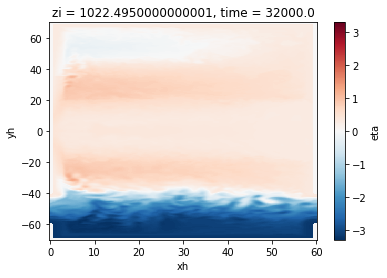

In [9]:
th1.eta[0,0,:].plot()

In [10]:
# interpolation
th_0125 = th1.interp(xh=g125.xh, yh=g125.yh)

### Compare original and interpolated data

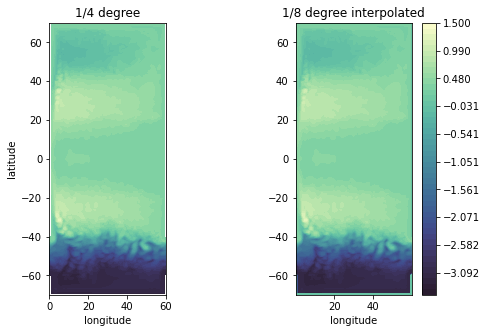

In [11]:
levs = np.linspace(-3.5,1.5,50)
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.contourf(snap_025.xh,snap_025.yh,snap_025.e[-1,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('1/4 degree')
plt.subplot(1,2,2)
plt.contourf(th_0125.xh,th_0125.yh,th_0125.eta[0,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.title('1/8 degree interpolated')
plt.colorbar()

In [12]:
th_0125 = th_0125
th_0125 = th_0125.fillna(0)
th_0125.to_netcdf(path1+dest+'/INPUT/'+dest+'_eta.nc')

### Run the 1/8 case and load the initial conditions

In [13]:
ic = xr.open_dataset(path1+dest+'/MOM_IC.nc', decode_times=False)

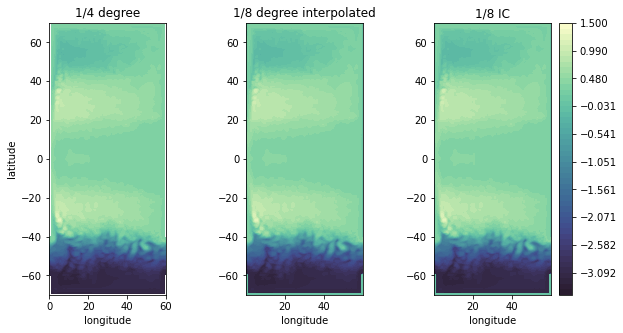

In [14]:
# compare eta original, interpolated and from IC
levs = np.linspace(-3.5,1.5,50)
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.contourf(snap_025.xh,snap_025.yh,snap_025.e[-1,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('1/4 degree')
plt.subplot(1,3,2)
plt.contourf(th_0125.xh,th_0125.yh,th_0125.eta[0,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.title('1/8 degree interpolated')
plt.subplot(1,3,3)
plt.contourf(ic.lonh,ic.lath,ic.eta[0,0], cmap=cmocean.cm.deep_r,levels=levs)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude')
plt.title('1/8 IC')
plt.colorbar()

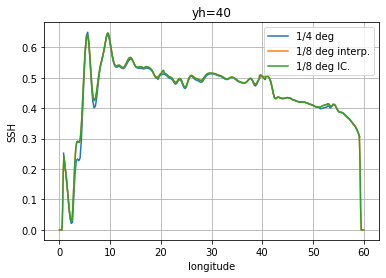

In [15]:
plt.figure()
plt.plot(snap_025.xh,snap_025.sel(yh=40, method='nearest').e[-1,0], label='1/4 deg')
plt.plot(th_0125.xh,th_0125.sel(yh=40, method='nearest').eta[0,0], label='1/8 deg interp.')
plt.plot(ic.lonh,ic.sel(lath=40, method='nearest').eta[0,0], label='1/8 deg IC.')
plt.legend()
plt.title('yh=40')
plt.xlabel('longitude')
plt.ylabel('SSH')
plt.grid()

Text(0, 0.5, 'SSH')

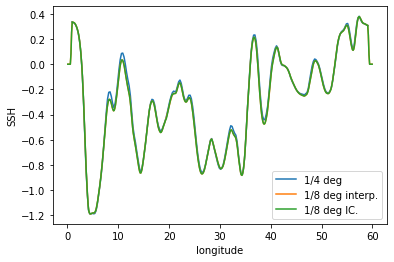

In [16]:
plt.figure()
plt.plot(snap_025.xh,snap_025.sel(yh=-40, method='nearest').e[-1,0], label='1/4 deg')
plt.plot(th_0125.xh,th_0125.sel(yh=-40, method='nearest').eta[0,0], label='1/8 deg interp.')
plt.plot(ic.lonh,ic.sel(lath=-40, method='nearest').eta[0,0], label='1/8 deg IC.')
plt.legend()
plt.xlabel('longitude')
plt.ylabel('SSH')